In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

df = pd.read_excel('Inputs/retail-dataset-analysis.xlsx')

df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

### Analyse the data to find the best-selling products and the periods during which sales peaked.

In [2]:
best_selling_products = df.groupby('PRODUCTCODE')['SALES'].sum().sort_values(ascending=False).reset_index()
print(best_selling_products)
best_selling_products.head().to_csv('Outputs/Files/best_selling_products.csv')

    PRODUCTCODE      SALES
0      S18_3232  264155.63
1      S24_3856  156050.39
2      S18_4600  151684.50
3      S24_2300  148056.00
4      S18_2238  143886.00
..          ...        ...
104    S24_2972   74148.44
105    S24_2022   71722.98
106    S32_2206   68394.21
107    S24_1937   67738.38
108    S24_3969   58826.66

[109 rows x 2 columns]


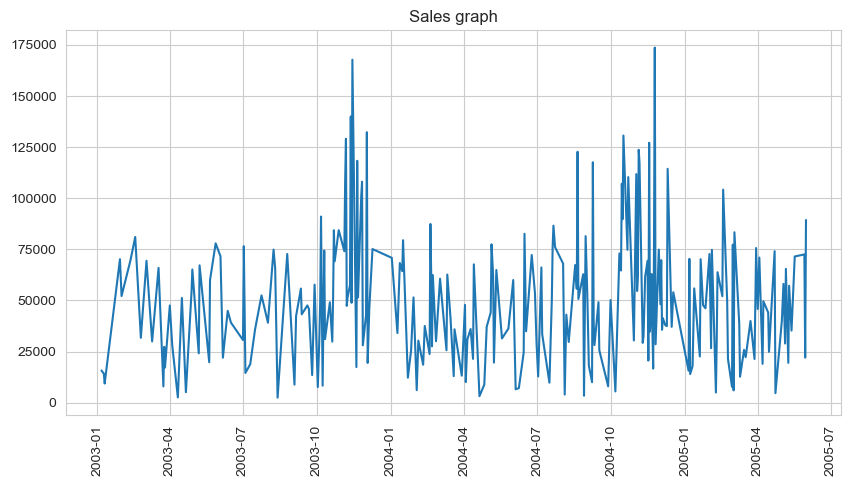

In [3]:
sales_graph = df.groupby('ORDERDATE')['SALES'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(sales_graph['ORDERDATE'], sales_graph['SALES'])
plt.xticks(rotation=90)

plt.title('Sales graph')

plt.savefig('Outputs/Images/Q1-1.png')
plt.show()

### Calculate total sales revenue, the number of transactions, and average order value.
### Visualize these metrics over time to identify trends.

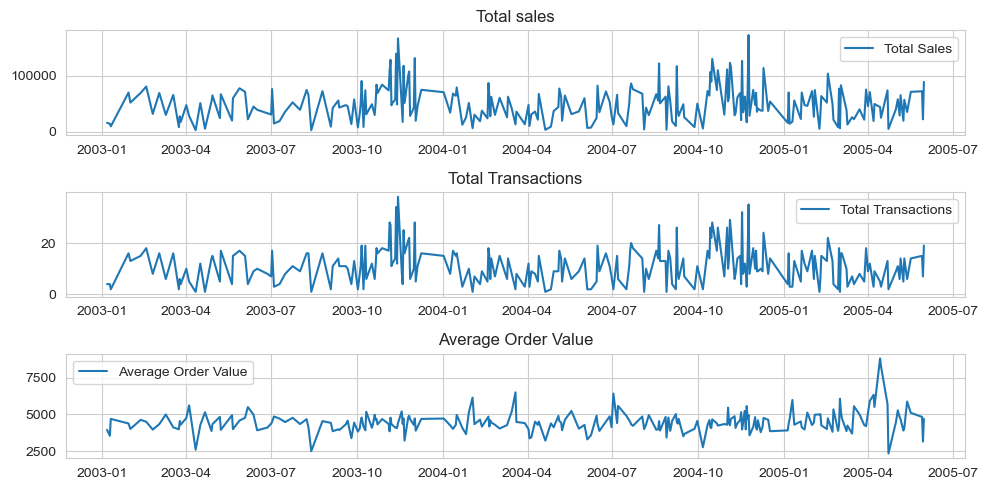

In [4]:
trends = df.groupby('ORDERDATE').agg(
    total_sales = ('SALES', 'sum'),
    total_trans = ('ORDERNUMBER', 'count'),
    avg_order_value = ('SALES', 'mean')
).reset_index()

fix, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(trends['ORDERDATE'], trends['total_sales'])
ax[0].legend(['Total Sales'])
ax[0].set_title('Total sales')

ax[1].plot(trends['ORDERDATE'], trends['total_trans'])
ax[1].legend(['Total Transactions'])
ax[1].set_title('Total Transactions')

ax[2].plot(trends['ORDERDATE'], trends['avg_order_value'])
ax[2].legend(['Average Order Value'])
ax[2].set_title('Average Order Value')

plt.tight_layout()

plt.savefig('Outputs/Images/Q1-2.png')

plt.show()

### Determine the profit margins for each product and identify the products with the highest sales

In [5]:
df['profit'] = df['SALES'] - (df['QUANTITYORDERED'] * df['COSTPRICE'])

products_profit_margin = df.groupby('PRODUCTCODE')[['profit', 'SALES']].sum().reset_index()

products_profit_margin['Profit Margin'] = products_profit_margin['profit'] / products_profit_margin['SALES']

products_profit_margin.to_csv('Outputs/Files/products_profit_margin.csv')

print('the profit margin is save to Outputs/Files/products_profit_margin.csv')

products_profit_margin = products_profit_margin.reset_index().sort_values(by='SALES', ascending=False)

print("Highest Sales product is ", products_profit_margin.loc[0]['PRODUCTCODE'])

the profit margin is save to Outputs/Files/products_profit_margin.csv
Highest Sales product is  S10_1678


### Visualise the distribution of revenue across different product categories.

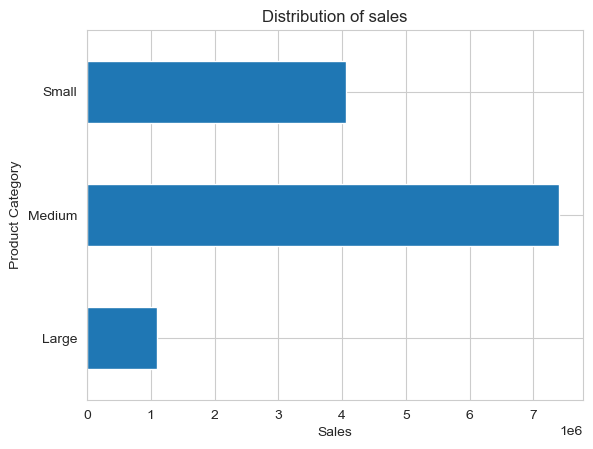

In [6]:
product_dist = df.groupby('DEALSIZE')['SALES'].sum()

product_dist.plot(kind='barh')

plt.title('Distribution of sales')
plt.xlabel("Sales")
plt.ylabel("Product Category")

plt.savefig('Outputs/Images/Q1-4.png')

plt.show()

### Determine the average spending per customer and compare them.

In [7]:
customer = df.groupby('CUSTOMERNAME')['SALES'].mean().reset_index(name='Average Spending')

customer.to_csv('Outputs/Files/Q1-5.csv')

print('output is saved to Outputs/Files/Q1-5.csv')

output is saved to Outputs/Files/Q1-5.csv


### Visualize the distribution of customer country.

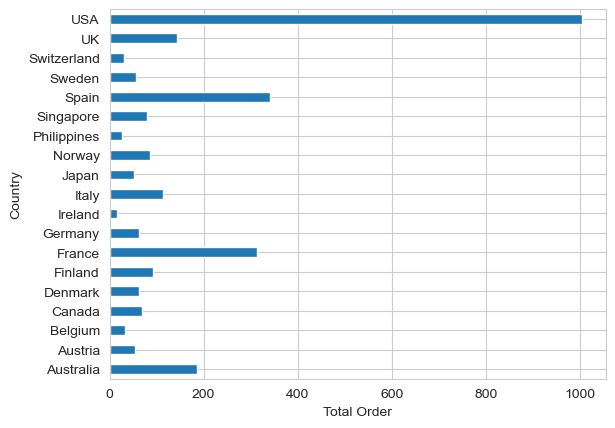

In [8]:
country = df.groupby('COUNTRY')['SALES'].size()

country.plot(kind='barh')
plt.ylabel("Country")
plt.xlabel("Total Order")

plt.savefig('Outputs/Images/Q1-6.png')

plt.show()

### Use K-Means clustering to segment customers based on relevant features (e.g.,country, spending behaviour). Based on the customer segments, suggest products that could be recommended to each segment.

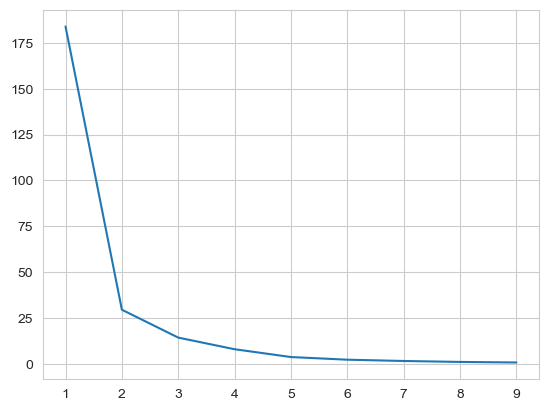

the recommended product is save to Outputs/Files/Q1-7.csv


In [9]:
## buy quantity, sales
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features = df.groupby('CUSTOMERNAME')[['SALES','QUANTITYORDERED']].sum().reset_index()
features[['sales_t', 'quantity_t']] = scaler.fit_transform(features[['SALES', 'QUANTITYORDERED']])

def find_k(data, max_k):
    means = []
    inertias =[]
    
    for i in range(1, max_k):
        means.append(i)
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    plt.plot(means, inertias)
    plt.show()
    
find_k(features[['sales_t', 'quantity_t']], 10)

kmeans = KMeans(n_clusters=3)

kmeans.fit(features[['SALES', 'QUANTITYORDERED']])

features['cluster'] = kmeans.labels_

features = features[['CUSTOMERNAME', 'cluster']]

features = df.merge(features, on='CUSTOMERNAME')

features = features.groupby(['cluster', 'PRODUCTCODE']).size().reset_index(name='Count').sort_values(by=['cluster', 'Count'], ascending=[True, False])

features = features.groupby('cluster').head(3)

features[['cluster', 'PRODUCTCODE']].to_csv('Outputs/Files/Q1-7.csv')

print('the recommended product is save to Outputs/Files/Q1-7.csv')

## Visualize the characteristics of each customer segment.

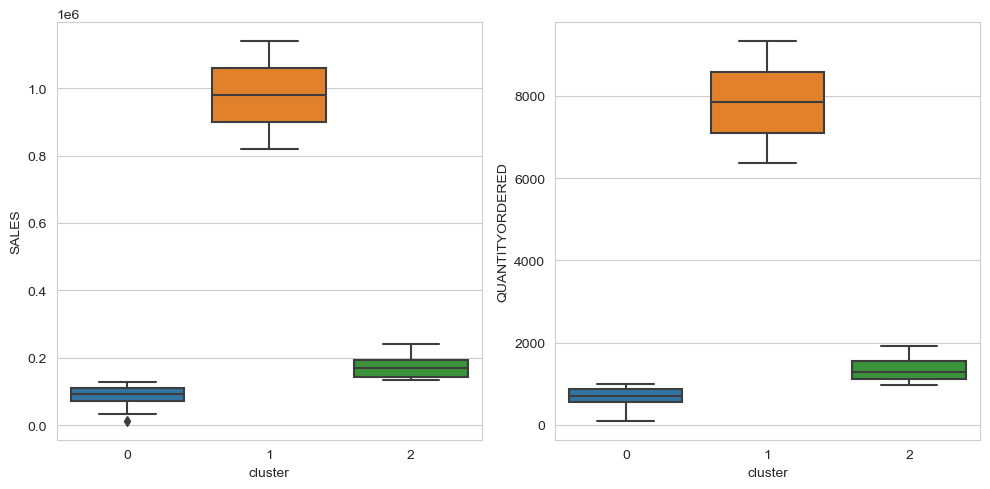

In [10]:
import seaborn as sns

features = df.groupby('CUSTOMERNAME')[['SALES','QUANTITYORDERED']].sum().reset_index()
features['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=features['cluster'], y=features['SALES'])

plt.subplot(1, 2, 2)
sns.boxplot(x=features['cluster'], y=features['QUANTITYORDERED'])

plt.tight_layout()
plt.show()

## Part 2 - Time Series Forecasting

In [11]:
df = pd.read_csv('Inputs/Q3a - Netflix_stock_history.csv')

df['Date'] = pd.to_datetime(df['Date'])

df = df[df['Date'] >= '2018-01-01']

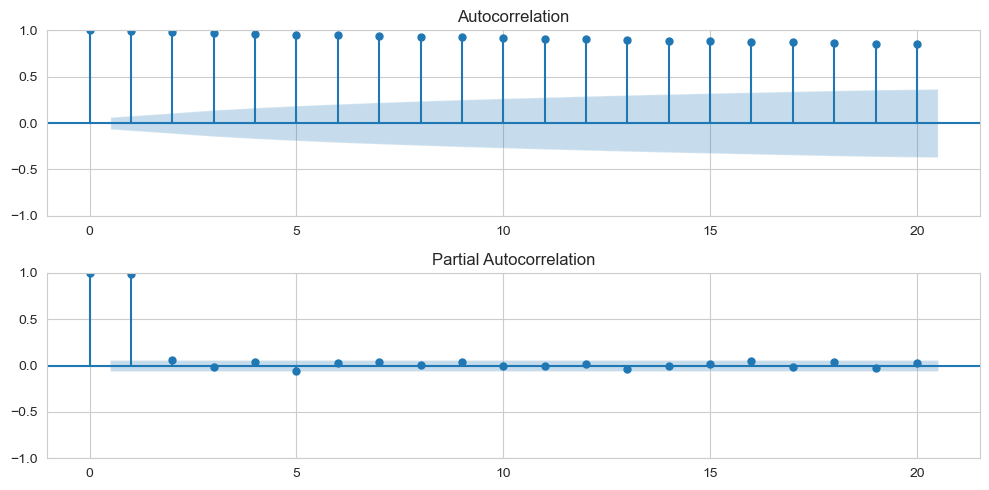

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 5))

plot_acf(df['Close'], ax=ax[0], lags=20)
plot_pacf(df['Close'], ax=ax[1], lags=20)

plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])

print(f'd value = {result[1]}')

d value = 0.6239514886929216


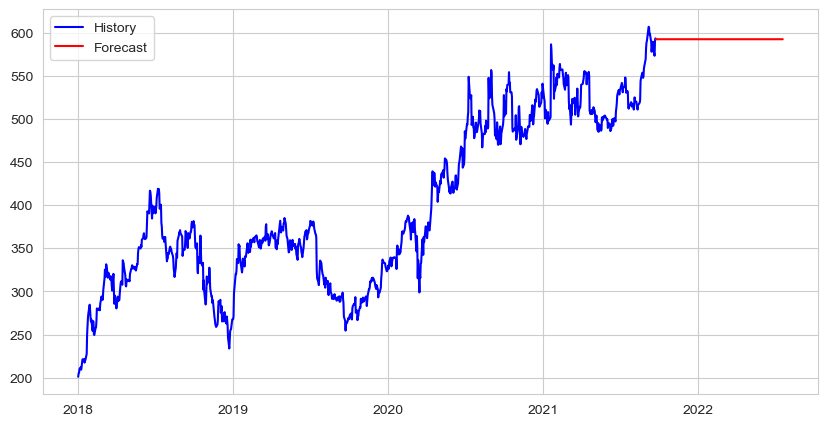

In [14]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

arima = ARIMA(df['Close'], order=(1, 1, 1))

model_fit = arima.fit()

plt.figure(figsize=(10, 5))

date_range = pd.date_range(start=df['Date'].max(), periods=300, freq='D')

plt.plot(df['Date'], df['Close'], color='blue', label='History')
plt.plot(date_range, model_fit.forecast(300), color='red', label='Forecast')

plt.legend(loc='best')
plt.show()

In [15]:
df_train = df[0:int(len(df) * 0.75)]
df_test = df[int(len(df) * 0.75):len(df)]

df_test = df_test['Close'].values
actual = [x for x in df_test]
predict = []

for i in range(len(df_test)):
    arima_model = ARIMA(actual, order=(1, 1, 1))
    model_fit = arima_model.fit()
    predict_ouptut = model_fit.forecast()[0]  
    predict.append(predict_ouptut)
    actual.append(df_test[i])
    
    # print(f"predict {predict_ouptut}, actual {df_test[i]}")

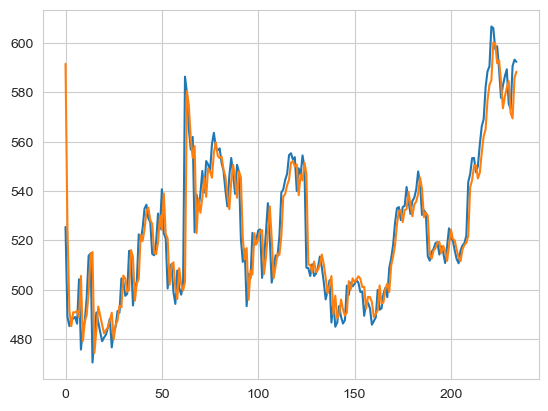

model performance RMSE: 7.523808426600381


In [16]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

plt.plot(df_test, label='Actual')
plt.plot(predict, label='Predict')
plt.show()

mae = mean_absolute_error(df_test, predict) 

print(f'model performance RMSE: {mae}')

## Price Elascity

In [17]:
from statsmodels.tools import add_constant
from statsmodels.tsa.stattools import OLS
import numpy as np
import pandas as pd

df = pd.read_csv('Inputs/Q2 - avocado.csv')
df = df[(df['type'] == 'conventional') & (df['region'] == 'California')]
# 
# using linear regression
# df = df[(df['region'] == 'California' )& (df['type'] == 'conventional')]
# 
# median_price = df['AveragePrice'].median()
# median_volume = df['Total Volume'].median()
# 
# df['priceDelta'] = (df['AveragePrice'] - median_price) / median_price
# df['volumeDelta'] = (df['Total Volume'] - median_volume) / median_volume
# 
# model = LinearRegression()
# model.fit(df[['priceDelta']], df['volumeDelta'])
# 
# ped = model.coef_[0]

log_price = np.log(df['AveragePrice'])
log_volume = np.log(df['Total Volume'])

X = add_constant(log_price)

ols = OLS(log_volume, X).fit()
ped = ols.params['AveragePrice']

print(ped)

-0.6813823667546581


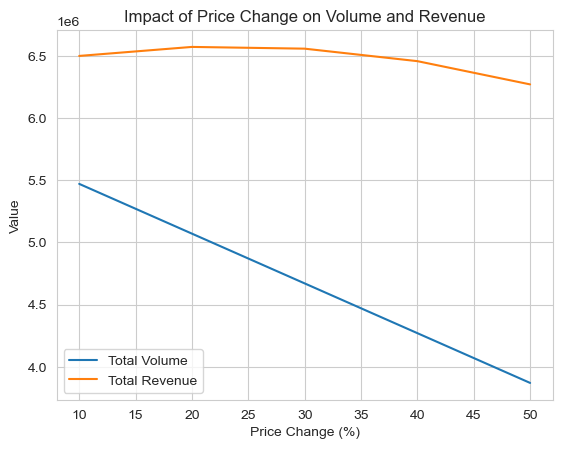

In [18]:
import matplotlib.pyplot as plt

change_of_prices = [10, 20, 30, 40, 50]

current_price = df['AveragePrice'].median()
current_volume = df['Total Volume'].median()

total_volume = []
total_revenue = []

for change_of_price in change_of_prices:

    change_of_price = change_of_price / 100
    
    new_price = current_price * (1 + change_of_price)

    new_volume = current_volume * (1 + (ped * change_of_price))
    new_revenue = new_price * new_volume

    total_volume.append(new_volume)
    total_revenue.append(new_revenue)

plt.plot(change_of_prices, total_volume, label='Total Volume')
plt.plot(change_of_prices, total_revenue, label='Total Revenue')

plt.xlabel('Price Change (%)')
plt.ylabel('Value')
plt.title('Impact of Price Change on Volume and Revenue')
plt.legend()

plt.show()

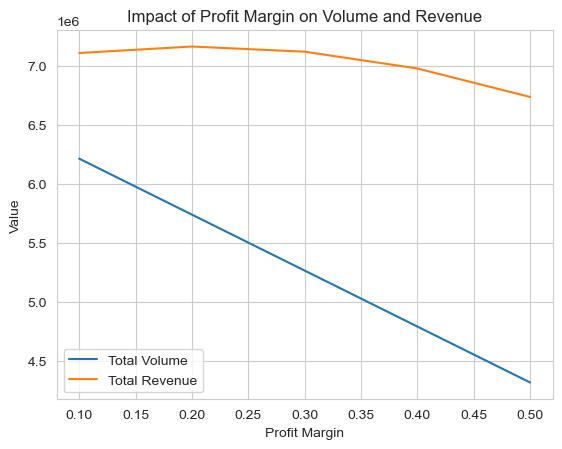

In [19]:
import matplotlib.pyplot as plt

desired_profit_margin = [0.1, 0.2, 0.3, 0.4, 0.5]

last_transaction = df[df['Date'] == df['Date'].max()]
current_price = last_transaction['AveragePrice'].values[0]
current_volume = last_transaction['Total Volume'].values[0]

total_volume = []
total_revenue = []

for profit_margin in desired_profit_margin:
    new_price = profit_margin * current_price + current_price
    change = new_price - current_price

    new_volume = current_volume * (1 + (ped * change))
    new_revenue = new_volume * new_price

    total_volume.append(new_volume)
    total_revenue.append(new_revenue)

plt.plot(desired_profit_margin, total_volume, label='Total Volume')
plt.plot(desired_profit_margin, total_revenue, label='Total Revenue')

plt.xlabel('Profit Margin')
plt.ylabel('Value')
plt.title('Impact of Profit Margin on Volume and Revenue')
plt.legend()

plt.show()

## CLTV 

In [20]:
df = pd.read_csv('Inputs/Q1-201904 sales reciepts.csv')

df = df[df['customer_id'] != 0]

df['transaction_date'] = pd.to_datetime(df['transaction_date'])

df['total price'] = df['quantity'] * df['unit_price']

customer = df.groupby('customer_id').agg({
    'total price' : 'sum',
    'transaction_id': 'count',
    'transaction_date': lambda x: (x.max() - x.min()).days / 365,
}).reset_index()

customer['average price'] = customer['total price'] / customer['transaction_id']

customer['cltv'] = customer['average price'] * customer['transaction_id'] * customer['transaction_date']

customer

,customer_id,total price,transaction_id,transaction_date,average price,cltv
0,1,29.20,8,0.073973,3.650000,2.160000
1,2,90.35,21,0.068493,4.302381,6.188356
2,3,188.90,31,0.063014,6.093548,11.903288
3,4,28.75,9,0.065753,3.194444,1.890411
4,5,23.50,6,0.076712,3.916667,1.802740
...,...,...,...,...,...,...
2242,8497,66.00,12,0.063014,5.500000,4.158904
2243,8498,39.75,9,0.065753,4.416667,2.613699
2244,8499,58.10,12,0.076712,4.841667,4.456986
2245,8500,90.85,21,0.063014,4.326190,5.724795


In [21]:
df_customer = pd.read_csv('Inputs/Q1-customer.csv')

customer = customer[['customer_id', 'cltv']].merge(df_customer, on="customer_id", how="left")

customer[['customer_id', 'cltv']].to_csv('Outputs/Files/Customer Segment.csv')

customer

,customer_id,cltv,home_store,customer_first-name,customer_email,customer_since,loyalty_card_number,birthdate,gender,birth_year
0,1,2.160000,3.0,Kelly Key,Venus@adipiscing.edu,2017-01-04,908-424-2890,1950-05-29,M,1950.0
1,2,6.188356,3.0,Clark Schroeder,Nora@fames.gov,2017-01-07,032-732-6308,1950-07-30,M,1950.0
2,3,11.903288,3.0,Elvis Cardenas,Brianna@tellus.edu,2017-01-10,459-375-9187,1950-09-30,M,1950.0
3,4,1.890411,3.0,Rafael Estes,Ina@non.gov,2017-01-13,576-640-9226,1950-12-01,M,1950.0
4,5,1.802740,3.0,Colin Lynn,Dale@Integer.com,2017-01-15,344-674-6569,1951-02-01,M,1951.0
...,...,...,...,...,...,...,...,...,...,...
2242,8497,4.158904,8.0,Rae,Kylie@facilisi.org,2017-01-06,081-440-6679,1977-12-10,F,1977.0
2243,8498,2.613699,8.0,April,Daniel@placerat.us,2019-01-20,705-545-5246,2000-12-07,N,2000.0
2244,8499,4.456986,8.0,Clementine,Dieter@ac.us,2017-11-09,297-550-7776,1996-06-04,F,1996.0
2245,8500,5.724795,8.0,Linda,Dillon@pretium.gov,2017-08-21,255-202-7435,1990-03-01,N,1990.0


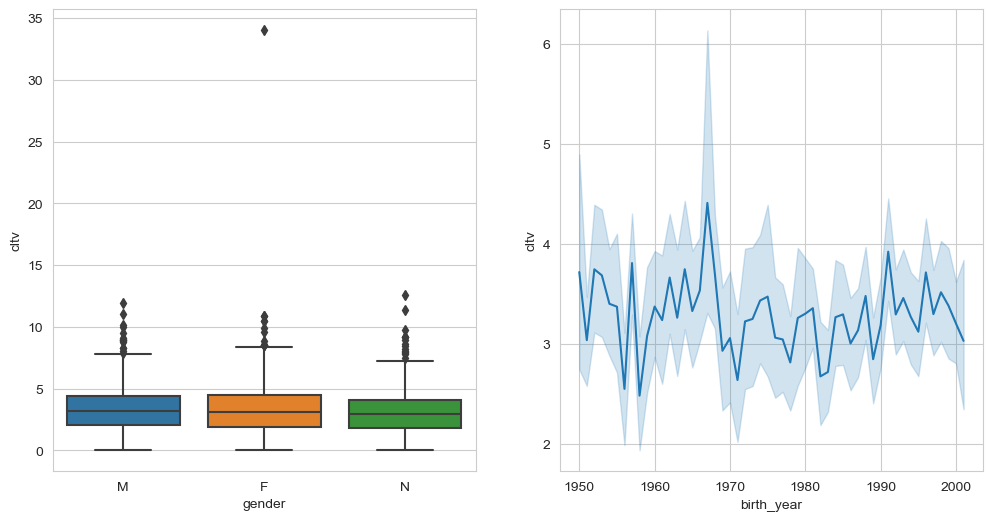

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='gender', y='cltv', data=customer)
plt.subplot(1, 2, 2)
sns.lineplot(x=customer['birth_year'], y=customer['cltv'])
plt.show()

### Churn rate

In [23]:
df = pd.read_csv('Inputs/customer_churn_dataset.csv')

df = df.dropna()
churn_rate = df['Churn'].mean() * 100

print(f"Overall Churn Rate: {churn_rate:.2f}%")

Overall Churn Rate: 56.71%


In [24]:
# Assuming 'CLTV' is a calculated metric, which you don't have here, let's create a mock CLTV for demonstration.
df['CLTV'] = df['Total Spend'] / df['Tenure']  # Just an example calculation

# Calculate average CLTV for churned and active customers
avg_cltv_churned = df[df['Churn'] == 1]['CLTV'].mean()

# Print CLTV summary
print(f"Average CLTV for Churned Customers: {avg_cltv_churned:.2f}")

Average CLTV for Churned Customers: 42.54


Churn Rate by Gender:
Gender
Female    66.669115
Male      49.126880
Name: Churn, dtype: float64


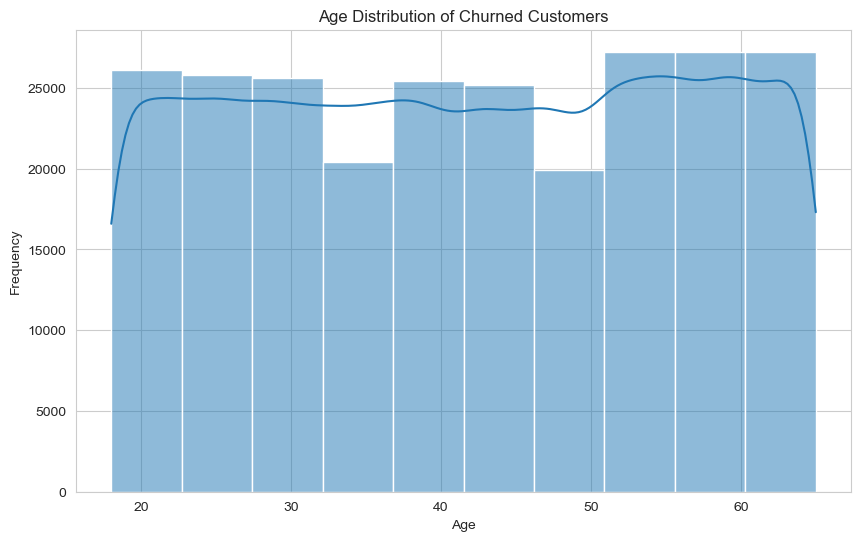

In [25]:
# Gender and churn rate
gender_churn = df.groupby('Gender')['Churn'].mean() * 100
print("Churn Rate by Gender:")
print(gender_churn)

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 1]['Age'], kde=True, bins=10)
plt.title('Age Distribution of Churned Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

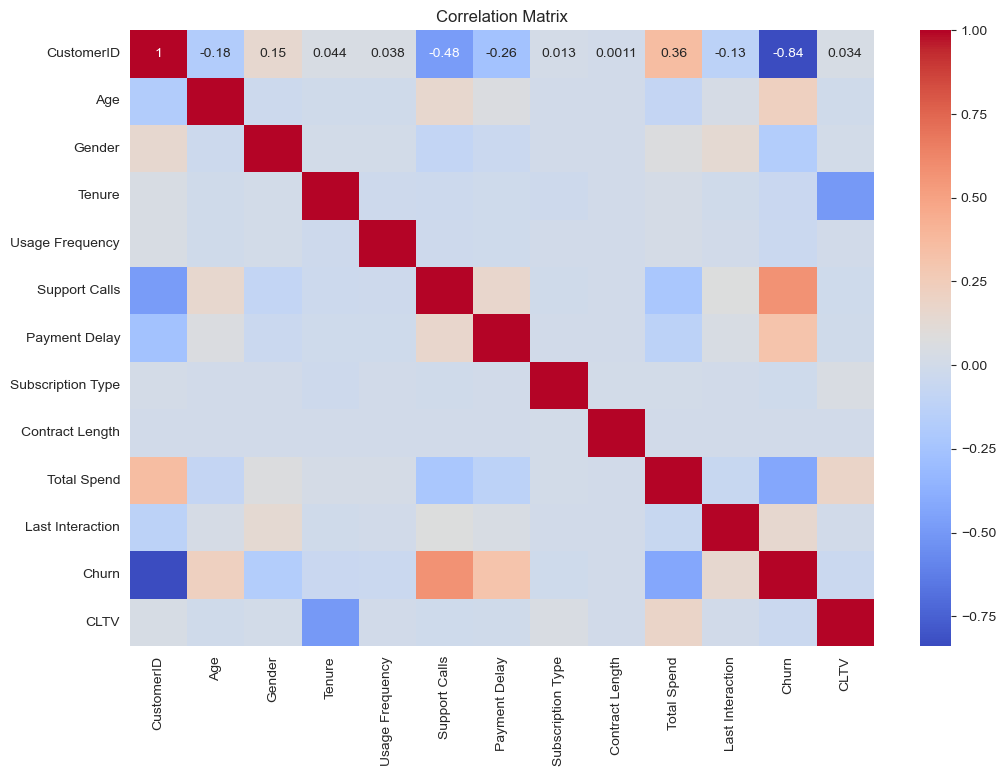

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Subscription Type'] = le.fit_transform(df['Subscription Type'])
df['Contract Length'] = le.fit_transform(df['Contract Length'])

# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()